### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.analysis_tools import *
from itertools import product
import os

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [2]:
mth = rets.index[6]
start_mth = mth + pd.DateOffset(months=1)
start_mth

Timestamp('2001-02-01 00:00:00')

In [40]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
#Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
cols = ['Vol']
Y = wrds_tics.loc[:,cols] # Y matrix in formulation

def vol_data_treatment(Y):
    Y.Vol = -1*Y.Vol/Y.Vol.std(axis=0) #for Vol Limit
    return Y

Y = vol_data_treatment(Y)

ret_constr = 0.01 #no return constraint
soft_margin = 0.25 #large preference for separation feasibility

name = "final"
ratio = 0.7 #% of assets
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)
epsilon = 1e-3 #epsilon hyper-parameter
non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
#epsilons = [1e-2, 1e-3, 1e-4]
#epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4"}

epsilons = [1e-2, 1e-3]
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3"}

card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}

dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [41]:
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
SVM_ = SVM(tics, Y , soft_margin*np.ones_like(mean), non_neg = non_negativity_setting, epsilon=epsilon)
SVM_MVO_Fast = SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 5)
SVM_MVO_Fast.MVO_.model.params.MIPGap = 0.05
SVM_MVO_Fast.MVO_.model.params.timelimit = 10
SVM_MVO_Fast.SVM_.model.params.timelimit = 60
SVM_MVO_Fast.MVO_.model.params.OutputFlag = 0
SVM_MVO_Fast.SVM_.model.params.OutputFlag = 0
SVM_MVO_Fast.track_change = True #determine global convergence if z has changed by more than 20%
SVM_MVO_Fast.change_threshold = 0.05 #if z has changed by twenty percent or more then we have achieved convergence
start = time.time()
SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln()
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()
print("Solution time", end - start)

Set parameter MIPGap to value 0.05
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 60
Initialization successful
ADM terminated with C =  0.25
Solution time 38.75928449630737


In [42]:
MVO_.decision_boundary

[array([-0.00603901]),
 array([-0.00234309]),
 array([-0.00562665]),
 array([-0.00095949]),
 array([-0.00547269]),
 array([-0.00598624]),
 array([-0.00087305]),
 array([-0.0005826]),
 array([-0.00243564]),
 array([-0.00036253]),
 array([-0.00059547]),
 array([-0.00193926]),
 array([-0.00121924]),
 array([-0.00922172]),
 array([-0.00144105]),
 array([-0.00163682]),
 array([-0.00436242]),
 array([-0.00351375]),
 array([-0.00079258]),
 array([-0.00224678]),
 array([-0.00302377]),
 array([-0.00517929]),
 array([-0.00137334]),
 array([-0.00181981]),
 array([-0.00078777]),
 array([-0.00215495]),
 array([-0.00099999]),
 array([-0.00355208]),
 array([-0.00105664]),
 array([-0.00088964]),
 array([-0.0008819]),
 array([-0.00119002]),
 array([-0.0007458]),
 array([-0.00771579]),
 array([-0.00134408]),
 array([-0.00830176]),
 array([-0.000903]),
 array([-0.00107291]),
 array([-0.00142647]),
 array([-0.00087869]),
 array([-0.00068024]),
 array([-0.00087604]),
 array([-0.00115039]),
 array([-0.00492

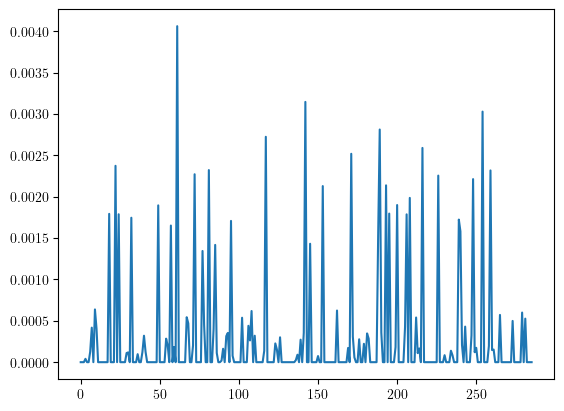

In [43]:
plt.plot(SVM_.xi.x)

In [44]:
Y

,Vol
tic,
AAPL,-1.658561
ABC,-0.643509
ABMD,-1.545308
ABT,-0.263517
ADBE,-1.503026
...,...
XOM,-0.130141
XRAY,-0.374216
XRX,-1.426769


In [45]:
n, m = Y.shape
predicted_signs = []
for i in range(n):
    a = SVM_.decision_boundary[i]
    print("Asset i", i)
    # self.model.addConstr((-1) * self.epsilon + self.xi[i] + big_m * self.z[i] >= a, "svm1")
    # self.model.addConstr(-1 * big_m * (1 - self.z[i]) + 1 * self.epsilon - self.xi[i] - a <= 0, "svm2")
    #print(2 * a[0] * MVO_.z[i].x - a[0])
    print("asset sign ", 2 * MVO_.z[i].x - 1)
    print("hyperplane ", SVM_.w.x)
    print("bias  ", SVM_.b.x)
    print("bias  ", Y.iloc[i])
    print("decision boundary asset ", i, " value ", a)
    print("predicted sign ", sign(a[0]))
    predicted_signs.append(sign(a[0]))
    print("slack ", i, " value ", SVM_.xi[i].x)

Asset i 0
asset sign  -1.0
hyperplane  [0.00364112]
bias   [7.02992761e-12]
bias   Vol   -1.658561
Name: AAPL, dtype: float64
decision boundary asset  0  value  [-0.00603901]
predicted sign  -1
slack  0  value  2.6604802157059326e-10
Asset i 1
asset sign  -1.0
hyperplane  [0.00364112]
bias   [7.02992761e-12]
bias   Vol   -0.643509
Name: ABC, dtype: float64
decision boundary asset  1  value  [-0.00234309]
predicted sign  -1
slack  1  value  2.6630658800411326e-10
Asset i 2
asset sign  -1.0
hyperplane  [0.00364112]
bias   [7.02992761e-12]
bias   Vol   -1.545308
Name: ABMD, dtype: float64
decision boundary asset  2  value  [-0.00562665]
predicted sign  -1
slack  2  value  2.660566769417188e-10
Asset i 3
asset sign  -1.0
hyperplane  [0.00364112]
bias   [7.02992761e-12]
bias   Vol   -0.263517
Name: ABT, dtype: float64
decision boundary asset  3  value  [-0.00095949]
predicted sign  -1
slack  3  value  4.050536156203324e-05
Asset i 4
asset sign  -1.0
hyperplane  [0.00364112]
bias   [7.029927

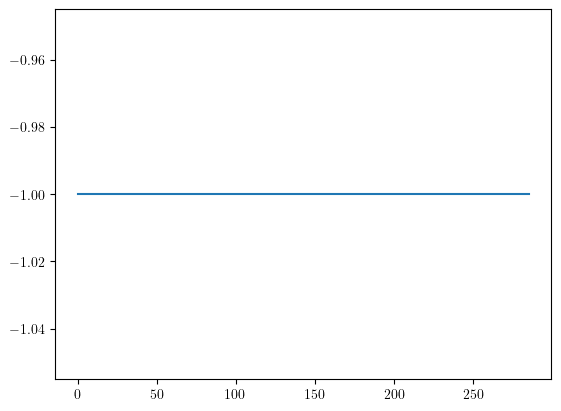

In [46]:
plt.plot(predicted_signs)

In [47]:
MVO2 = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y, AssetLim,\
             svm_choice = (True, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO2.set_model() #set up the model
MVO2.optimize() #find optimal solution
MVO2.model.params.outputflag = 0

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 862 rows, 860 columns and 3432 nonzeros
Model fingerprint: 0x6a82d82d
Model has 41042 quadratic objective terms
Variable types: 574 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Presolve removed 1 rows and 286 columns
Presolve time: 0.01s
Presolved: 861 rows, 574 columns, 3146 nonzeros
Presolved model has 41042 quadratic objective terms
Variable types: 288 continuous, 286 integer (286 binary)

Root relaxation: objective 5.854516e-04, 670 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.0005

In [48]:
(xs > 0.001).any(axis = 0)

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False,  True,  True, False, False,  True,
        True, False, False, False,  True, False,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False,

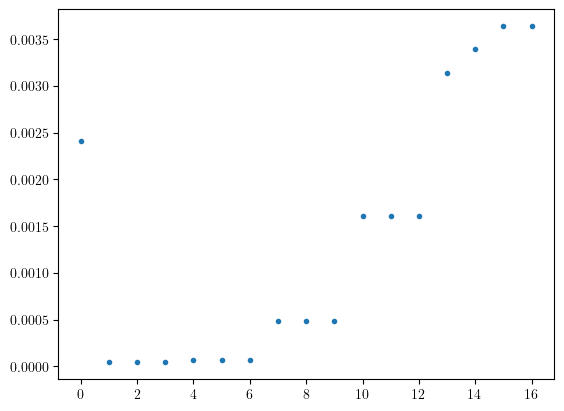

In [49]:
plt.plot(ws, '.')

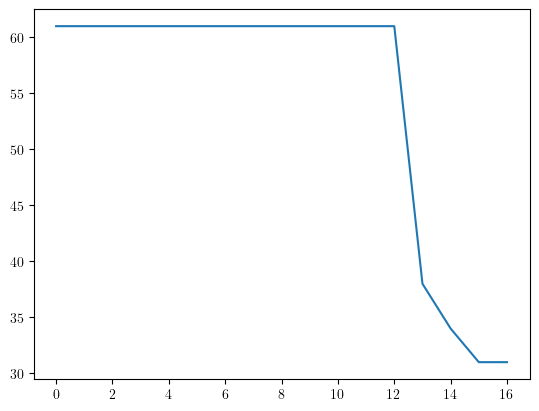

In [50]:
plt.plot(zs.sum(axis = 1))

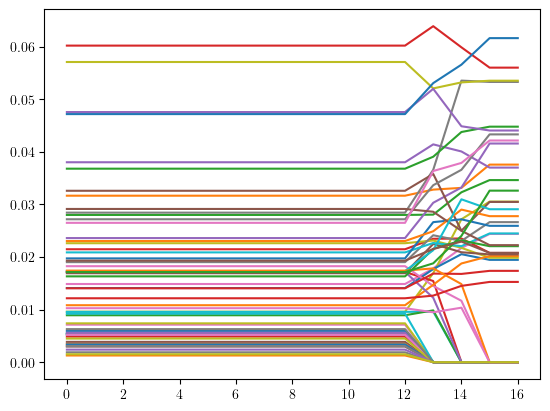

In [51]:
plt.plot(xs[:,(xs > 0.001).any(axis = 0)])

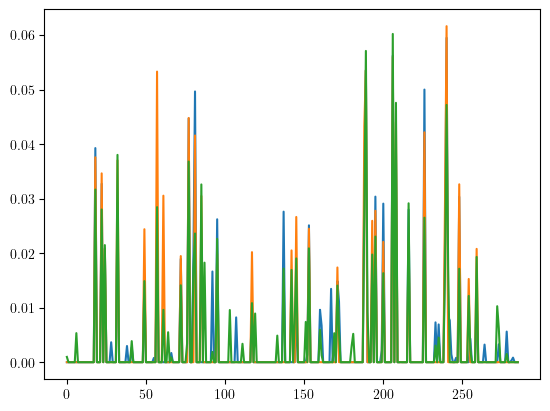

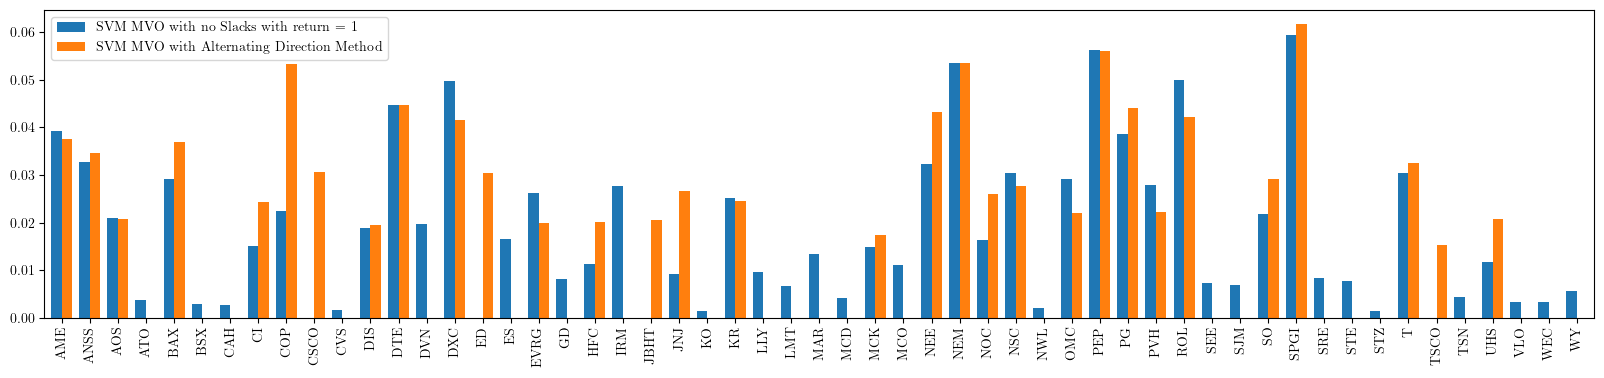

In [52]:
plt.plot(MVO2.x.x)
plt.plot(SVM_MVO_Fast.x.x)
plt.plot(xs[0,:])
out = pd.concat([MVO2.get_results(), SVM_MVO_Fast.get_results()], axis = 0)
out[out.columns[(out > 0.001).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [53]:
MVO2.b.x

array([0.03656919])

In [54]:
SVM_MVO_Fast.b.x

array([7.02992761e-12])

In [55]:
SVM_MVO_Fast.w.x

array([0.00364112])

In [56]:
MVO_.xi.x.sum()

0.08439778453905991

In [57]:
SVM_MVO_Fast.b.x/SVM_MVO_Fast.w.x

array([1.93070635e-09])

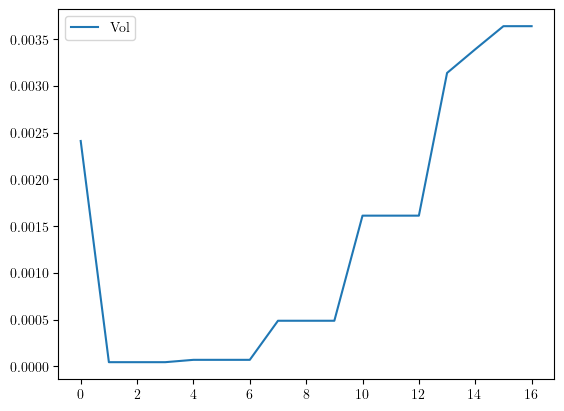

In [58]:
plt.plot(ws)
plt.legend(cols)

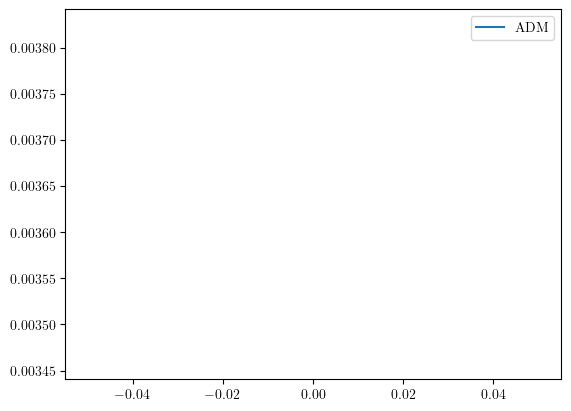

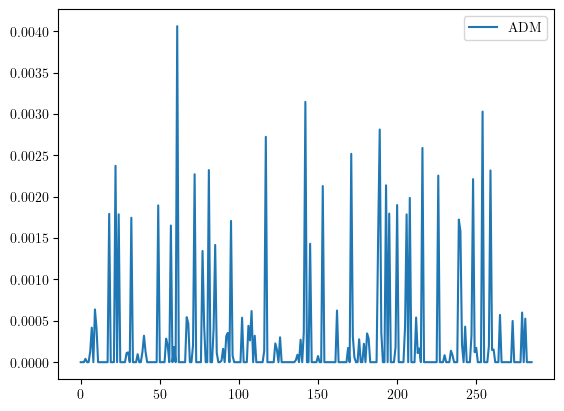

In [59]:
# plt.plot(SVM_MVO_Slck.w.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.w.x, label= 'ADM')
plt.legend();

plt.figure()
#plt.plot(SVM_MVO_Slck.xi.x, label = 'Slack')
plt.plot(SVM_MVO_Fast.xi_mvo.x, label= 'ADM')
plt.legend();

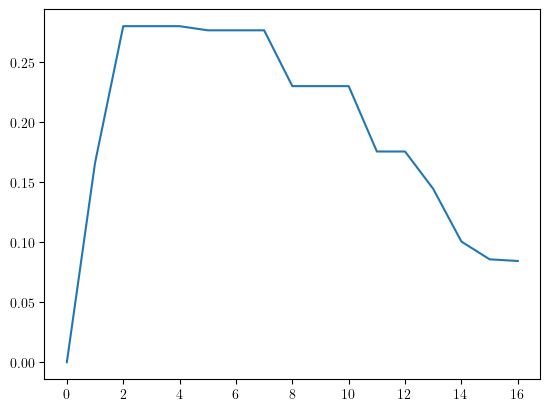

In [60]:
plt.plot(xi_mvo.sum(axis = 1))

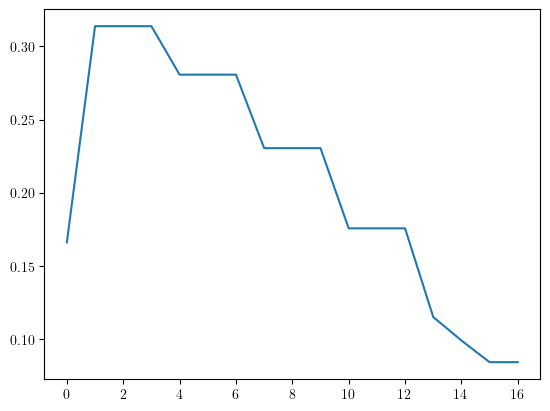

In [61]:
plt.plot(xi_svm.sum(axis = 1))

In [62]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

In [63]:
"".join(map(str, cols))

'Vol'

In [64]:
for ratio, epsilon in product(ratios, epsilons):
    AssetLim = math.floor(N*ratio)

    SVM_MVO_Fast.MVO_.AssetLim = AssetLim
    SVM_MVO_Fast.MVO_.epsilon = epsilon
    SVM_MVO_Fast.SVM_.epsilon = epsilon
    card_desc = card_desc_list[ratio]
    print("processing asset limit ", AssetLim)

    isExist = os.path.exists("cache/Local Experiments/"+epsilons_desc[epsilon])
    if not isExist:
        os.makedirs("cache/Local Experiments/"+epsilons_desc[epsilon])
        print("The new directory is created!")
    for i in range(len(turnovers)):
        turnover = turnovers[i]
        turnover_desc = turnover_descs[i]
        adm_results = evaluate_adm(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Fast, T, N, cols,
                 turnover, data_treatment=vol_data_treatment)
        col_string = "".join(map(str, cols))
        out_pth = "cache/Local Experiments/"+epsilons_desc[epsilon] + "/" + "padm" +card_desc + "_" +col_string + "_" +turnover_desc + name + ".pkl"
        with open(out_pth, 'wb') as fp:
            pkl.dump(adm_results, fp)
#end here for now - 1:32 AM 2022 - 10 22

processing asset limit  28
Begin Relaxation
ADM terminated with C =  1.0000000000000003e-05
_________________________
Iteration  0
Percent Complete  0.0
[4.53658886e-05]
_________________________
Iteration  12
Percent Complete  0.04938271604938271
[3.29722929e-05]
_________________________
Iteration  24
Percent Complete  0.09876543209876543
[3.77669123e-05]
_________________________
Iteration  36
Percent Complete  0.14814814814814814
[3.36138455e-05]
_________________________
Iteration  48
Percent Complete  0.19753086419753085
[3.21260309e-05]
_________________________
Iteration  60
Percent Complete  0.24691358024691357
[3.80170303e-05]
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
_________________________
Iteration  72
Percent Complete  0.2962962962962963
[4.51938455e-05]
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
Infeasible return constraint...Relaxing
_____________________

AttributeError: 'numpy.ndarray' object has no attribute 'x'